## Analyze A/B Test Results for New Web Page vs Old Webpage


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This notebook was created to Analyze obtained from client on an A/B test they conducted to see which if their new web page has helped to convert more users that their old web page. 

In this analysis we will be using the python programming language along with the pandas, numpy, matplotlib.pyplot, and statsmodel librarys to perform the analysis and provide a recommendation on which web page appeared to perform the best based on the data provided.

#### Analysis Note:
Because the dataset provided could have imperfections, incommplete or missing data, these recommendations only apply to the data provided.

<a id='probability'></a>
#### Part I - Probability

To get started, we imported several of the libraries needed for this analysis.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` We read in the `ab_data.csv` data and stored it in `df`.  

a. Read in the dataset and looked at the top few rows as well as looked at the spread in the timestamp data

In [2]:
#read in the ab dataset and do a quick check
#we found that this data was for about 22 days in Jan of 2017
df = pd.read_csv('ab_data.csv')
df.head()
df.timestamp.min(), df.timestamp.max(), df.head()

('2017-01-02 13:42:05.378582',
 '2017-01-24 13:41:54.460509',
    user_id                   timestamp      group landing_page  converted
 0   851104  2017-01-21 22:11:48.556739    control     old_page          0
 1   804228  2017-01-12 08:01:45.159739    control     old_page          0
 2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
 3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
 4   864975  2017-01-21 01:52:26.210827    control     old_page          1)

b. We found the number of rows in the dataset.

In [3]:
#checked to see how big the data set is
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
#since we only want unique users, we wanted to see how many there are
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
#since our investigation is at which page is better we 
#look to see how many converted overall
overall_converted = df.query('converted == 1')['user_id'].count()/df.shape[0]
overall_converted

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
#next we looked at the data for our groups and pages
#to see if there were any descrepencies
df.query('landing_page == "new_page" and group != "treatment"')['user_id'].count() + df.query("group == 'treatment' and landing_page != 'new_page'")['user_id'].count()

3893

f. We looked for any missing values?

In [7]:
#we also looked to see if there was any missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` 
## Data Cleaning

a. Since we found that there was not any missing data, and that there were some descrepencies in the data we created a new Dataframe df2 with only the correct values we were looking for where landing_pagea and control matched.

In [8]:
#next we created a dataframe from the orginal data, with just 
#the correct data for groups and pages (data cleaning)
df2 = df.query('(landing_page == "new_page" and group == "treatment") or (group == "control" and landing_page == "old_page")')

df2.shape[0]

290585

In [9]:
# Double Checked all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Data Cleaning Cont...

a. Numer of unique **user_id**s in **df2**?

In [10]:
#next we looked for any dupclicates
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. We found one user was duplicated and the removed one entry for that user keep the first one only.
c. Row for the duplicated user was 2893 and 1899

In [11]:
#we found one duplicate user
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
#looked at both duplicates
df2.loc[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removed **one** of the rows with a duplicate **user_id**

In [13]:
#kept the first enrty. Since they were the same besides time
df2 = df2.drop_duplicates(subset='user_id', keep='first')
df2.loc[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` **Data Investigaion**

a. Since we were interested in the conversion for these two pages, we first looked at data provided on conversion rate

In [14]:
#the probability that anyone might convert reguardless of the page
df2['converted'].mean()



0.11959708724499628

b. Given that an individual was in the `control` group, the probability they converted.

In [15]:
#probability of the control converting reguradless of page
p_control = df2.query('group == "control"')['converted'].mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, the probability they converted.

In [16]:
#probability of the treatment group converting requardless of page
p_treatment = df2.query('group == "treatment"')['converted'].mean()
p_treatment

0.11880806551510564

In [17]:
#the observed difference of the new page and the old page or p_new-p_old
#we will use this to determine if this data fits into our null or alternate hypothesis
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

d. The probability that an individual received the new page.

In [18]:
#The probablity that person received a new page regaurdles of the group
df2.query('landing_page == "new_page"').count()['converted']/df2.shape[0]

0.50006194422266881

e. Below are some intial thoughts on what was found in Part 1

**Initial look at probability**

Given what we found above it would appear that there is evidence to support that the old page is perfroming better than the new page. However, we need to invetigate further and look at the length of this comparison and do some a/b test simulations as well to get more information before making any conclusions. 

We will also use a z-test to check those numbers and make sure we have done the distributions correctly. 

<a id='ab_test'></a>
### Part II - A/B Test


Because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  However it is difficult to know if 22 days is long enougth to get through user bias around change. For this part of the anaysis we will concentrate on the covnversion rate of the new vs web page.

`1.`
**We will be testing to see if the new page is better than that old, we are assuming that the old page is better unless the new page proves better by at least a Type I error rate of 5%**

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$


**$p_{old}$ and $p_{new}$ are the mean values of conversions for the Old page and the new page, respectivley.**

`2.` We will ssume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we assumed they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We used a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Below, we performed the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. The **conversion rate** for $p_{new}$ under the null. 

In [19]:
#found the conversion rate for the new page which we determined to be the the overall success rate
#under the null
p_new = (df2.converted).mean()
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null. <br><br>

In [20]:
#found the conversion rate for the old page which we determined to be the the overall success rate
#under the null
p_old = (df2.converted).mean()
p_old

0.11959708724499628

c. $n_{new}$, is the number of individuals in the treatment group.

In [21]:
#the number of those getting the new page
n_new = df2.query('landing_page == "new_page"').count()["user_id"]
n_new

145310

d. $n_{old}$, is the number of individuals in the control group.

In [22]:
#the number of those geting the old page
n_old = df2.query('landing_page == "old_page"').count()["user_id"]
n_old

145274

e. Simulation of $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  

In [23]:
#simulate using number of new transactions with the conversion rate of the new page
new_page_converted = np.random.choice([0,1], n_new, p=(1-p_new,p_new ))
#the new page simulated conversion rate
new_page_converted.mean()

0.11948248572018444

f. Simulation of $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  S

In [24]:
#simulate using the number of people getting the old page using the old page conversion rate
old_page_converted = np.random.choice([0,1], n_old, p=(1-p_old, p_old))
#the old page simulated conversion rate
old_page_converted.mean()

0.12064099563583298

g. Found $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [25]:
#the difference in the conversion rates which we expect to be zero
new_page_converted.mean() - old_page_converted.mean()

-0.0011585099156485451

h. Created a bootstrap sample of 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process in parts (a) through (g) above. This allows us to run 10,000 tests and the law of large numbers to simulate a much larger sample size.

In [27]:
#next we bootstrap samples 

p_diffs = []
for n in range(10000):
    np_con = np.random.choice([0,1], n_new, p=(1-p_new,p_new ))
    op_con = np.random.choice([0,1], n_old, p=(1-p_old, p_old))
    diff = np_con.mean() - op_con.mean()
    p_diffs.append(diff)
np.array(p_diffs).mean()

-1.8496274170259134e-06

i. A histogram of the bootstrap samples **p_diffs**.  We also added the observed values from the orginal dataset found in 1(c).

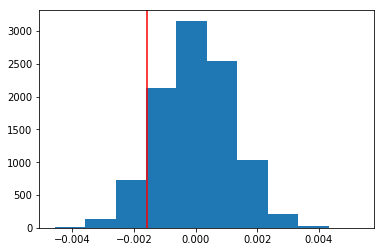

In [28]:
#plot a historgram with our observed difference to see if it falls within the null samples
std_pdiffs = np.std(p_diffs)
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color="red");


j. The proportion of the our bootstap samples that are greater than the actual difference observed in **ab_data.csv**

In [29]:
#We need to know the proportion of of test that fell above the observed difference
#in the acutal data
(p_diffs > obs_diff).mean()

0.90749999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Sampling preliminary conclusions**

After creating samples and using bootstraping, our pvalue was .908 and far above the Type I error rate of 0.05. Therefore it's a strong indicator that we should **not reject the null** in this case and likely stay with the old page. 

However, to ensure that our tests were done properly, we need another method to check this value against. Next, we completed a ztest using the statsmodel ztest function. If we get a similiar result to the above, we have further evidence that we should not reject the null and that we did our calculation correctly.

l. Below we calculated the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively. First, we imported the statsmodels library.

In [30]:
#imported the statsmodel library
import statsmodels.api as sm
#calculated the totals of the converted control and treatment groups
convert_old = sum((df2.group == 'control') & (df2.converted == 1)) 
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1)) 
#found the total number of each page
n_old = (df2.landing_page == 'old_page').value_counts()[True]
n_new = (df2.landing_page == 'new_page').value_counts()[True]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. We used `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link if you want to learn more.

In [31]:
#z_score is the std deviation and p_value is the pvalue of this data calculated by 
#the statsmodel ztest function
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger') 
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. Below are the findings from the z_test and how they compared to the bootstrapped sampling.

**Z-Test Results**

After completing the z-test, we do have aggreement with our distibution sampling that our pvaule is about .91. This indicates that given all other data being equal, we should **not reject the null** in this case and should instead recommend using the old_page.  


<a id='regression'></a>
### Part III - A regression approach

`1.`Lastly to further confirm our findings and to look at one other metric, location, we used logitic regression on this data set as well. 

a. The reasoning for this approach is below. 

**Regression Approach**

Because we have a row that is either conversion or no conversion, we are going to use logistic regression for this case as the result is binomial. We will start by splitting the conversion into to columns, we will then drop one of them in order to compare them acurately.

b. First, we added an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
#the model needs an intercept so we provide that.
df2['intercept'] = 1
df2[['group1','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('group1', axis=1)
#Aquick look at the new dataframe after adding these columns
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Next we used statsmodels logistic regression function to look at our a/b comparision from above. 

In [33]:
#since converted is what we want to predict it is the y value, while ab_page is the predictor in this case
y= df2['converted']
x = df2[['intercept', 'ab_page']]
log_mod = sm.Logit(y,x)
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of the model above

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        01:56:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. Below are the results from the Logigistic Regression

**Logit Results**

In this test, we found the pvalue to be .190 which is different than the tests we did in part 2. However, logit is a two tailed test. Therefore our null is 
$$H_0: p_{old} = 0$$


$$H_1: p_{new} \neq 0$$

where the former was the 

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$

Given that infomration we have found that this test further confirms what we did in part 2. 

All other things being equal we should **not reject the null** becuase the pvalue .190 is greater than the 0.05 error rate.

f. Other factors we may or may not consider

**Other considerations**

While we did find evidence to not reject the null in all cases, it might be good to investigate some other factors like location or even time. However, with time it might be difficult to know how long to conduct the testing for and our data, may not have enough samples over a significant period. Coninuing the study for an extended period might be good, but we must work with the data we already have.

Instead looking at the country along with the conversion rate would give use some potenial insights quickly without the variable of time allowing us to determine if certain areas should use the new page in certain countries.

g. Now along with testing if the conversion rate changes for different pages, we also added an effect based on which country a user lives in. We first read in the **countries.csv** dataset and merged together with df2.  i

In [35]:
#here we joined the country data with the dataframe based on user_id
country_data = pd.read_csv('countries.csv')
df2 = df2.join(country_data, lsuffix='user_id', rsuffix='user_id')


In [36]:
#we dropped the extra userid field
df2 = df2.drop(df2['user_iduser_id'], axis=1)
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
0,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK
1,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK
3,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK
4,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK


In [37]:
#This is a quick examimation of the data to see if we think there might be some significance of the location
uk_mean = df2.query("country == 'UK' and group == 'treatment'")['converted'].mean() - df2.query("country == 'UK' and group == 'control'")['converted'].mean()
us_mean = df2.query("country == 'US' and group == 'treatment'")['converted'].mean() - df2.query("country == 'US' and group == 'control'")['converted'].mean() 
ca_mean = df2.query("country == 'CA' and group == 'treatment'")['converted'].mean() - df2.query("country == 'CA' and group == 'control'")['converted'].mean()
print(uk_mean, us_mean,ca_mean)

-0.00116621485786 -0.00241283252808 0.00629272518173


**Quick Look at Country Data**
In a quick investigation of the country data, it looks like there may be some evidence that the new_page is performing better in Canada and the US. Below we will invesigate further to find out.

In [38]:
##Here we created separte columns for the countries
df2[['uk','us','ca']] = pd.get_dummies(df2['country'])
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,uk,us,ca
0,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK,0,1,0
1,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK,0,1,0
3,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK,0,1,0
4,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK,0,1,0


In [39]:
#we then dropped off uk for the logistic regression
df2 = df2.drop('uk', axis=1)
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,us,ca
0,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK,1,0
1,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK,1,0
3,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK,1,0
4,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK,1,0


In [40]:
#we then created a column with a score for each row based on the counrtry and page it received
df2['ca_page']= df2['ab_page']*df2['ca']
df2['us_page']= df2['ab_page']*df2['us']
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,us,ca,ca_page,us_page
0,2017-01-21 22:11:48.556739,control,old_page,0,1,0,UK,1,0,0,0
1,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
2,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,UK,1,0,0,1
3,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,UK,1,0,0,1
4,2017-01-21 01:52:26.210827,control,old_page,1,1,0,UK,1,0,0,0


h. Next we completed the logistic regression based on the location as well.   

In [41]:
y = df2['converted']
x = df2[['intercept', 'ab_page','ca_page','us_page']]
cmod = sm.Logit(y,x)
res = cmod.fit()


Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


In [42]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 14 May 2019   Pseudo R-squ.:               1.082e-05
Time:                        01:56:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.5119
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0020      0.033     -0.060      0.952      -0.067       0.063
ca_page       -0.0171      0.034     -0.507      0.612      -0.083       0.049
us_page       -0.0049      0.036     -0.134      0.893      -0.076       0.066
==============================================================================
"""

**Regression of Contry Data Summary**
Even when broken up, the analysis suggests what we should not reject the null hypothesis. None of the values were statistically significant for any of the countries. 

There is some evidence that the new page performs slightly better in Canda in particular, but it is not statiscially significant.


**Conclusions**
**Summary Finding Warning**
It needs to be stated that these conclusions are based only on the data provided and therefore could be incomplete or incorrect.

##Findings and Recommendations
After investigating this data set in multiple ways, we would recommend **not rejecting the null hypothesis** and therefore continuing to use the old page. 

Looking back at the analysis we looked at the following hypothesis:
Therefore our null is 

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$

In the first explorations, we our data supported not rejecting the null with a .910 pvalue which is far above the accecpted error rate of 0.05.

Our actual data from Part I and sample data, bootstrap sample, and z-test from Part II all showed very similar results. Further our Logistic Regression analysis in Part III further supported that we should no reject the null hypothesis. 





## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [43]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0